# 总结：

End2end训练一个MobileNete的**回归模型**对照片进行美观度打分。

整体分类准确率基本维持在69%-70%附近。其中：
1. 正样本预测准确率为69%，召回率为72%
2. 负样本预测准确率为70%，召回率为68%

与ImageNet Pretrained的mobilenet相比，准召上恰好互补。因此有理由相信二者的bagging会带来准召的进一步提升。

## 训练

In [1]:
from keras.applications.mobilenet import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input

from keras.models import Model, Sequential, save_model, load_model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Activation, Add, Lambda, Concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dropout
from keras import optimizers
import keras.backend as K
import numpy as np

Using TensorFlow backend.


In [2]:
input_shape = (224, 224, 3)

img = Input(shape=input_shape)

mobilenet = MobileNet(input_shape=input_shape, weights=None, include_top=False, pooling='avg')
x = mobilenet(img)
x = Dense(1024, activation='selu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

output = Dense(1, activation="linear")(x)

aesthetic_model = Model(inputs=img, outputs=output)

optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
aesthetic_model.compile(optimizer=optimizer,
              loss='mse',
              metrics=['mae'])

aesthetic_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenet_1.00_224 (Model)   (None, 1024)              3228864   
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1025      
Total params: 4,283,585
Trainable params: 4,259,649
Non-trainable params: 23,936
_____________________________________________________________

In [3]:
import pandas as pd
import random

trainset = pd.read_csv("./data/train.lst", 
                       dtype={"imgid": np.str, "rating": np.float, "label": np.int}).values.tolist()
testset = pd.read_csv("./data/test.lst", 
                      dtype={"imgid": np.str, "rating": np.float, "label": np.int}).values.tolist()
batch_size = 16

img_path = "../dataset/AVA/imgs/"

def random_crop(image, crop_size):
    w, h = image.shape[:-1]
    rangew = w - crop_size[0]
    rangeh = h - crop_size[1]
    assert(rangew >= 0 and rangeh >= 0)
    offsetw = 0 if rangew == 0 else np.random.randint(rangew)
    offseth = 0 if rangeh == 0 else np.random.randint(rangeh)
    return image[offsetw:offsetw+crop_size[0], offseth:offseth+crop_size[1], :]

def load_img_array(imgid, target_size):
    filename = img_path+"%s.jpg"%imgid
    img = image.load_img(filename, target_size=(256, 256))
    x = image.img_to_array(img)
    x = preprocess_input(x)
    cropped_x = random_crop(x, crop_size=target_size)
    return cropped_x

def generate_batch(dataset, batch_size, target_size, shuffle=True):
    while True:
        if shuffle:
            random.shuffle(dataset)
            
        for index in range(0, len(dataset), batch_size):
            if index + batch_size > len(dataset):
                current_batch_size = len(dataset) - index
            else:
                current_batch_size = batch_size
            index_array = dataset[index:index+current_batch_size]
            
            batch_x = np.zeros((current_batch_size, ) + target_size, dtype=K.floatx())
            batch_y = np.zeros((current_batch_size, ), dtype=K.floatx())
            for i, (imgid, rating, label) in enumerate(index_array):
                x = load_img_array(imgid, target_size)
                batch_x[i] = x
                batch_y[i] = rating
            yield (batch_x, batch_y)

In [4]:
rating = np.array(map(lambda x: x[1], trainset))
print "Max rating of trainset: %.3f"%rating.max()
print "Min rating of trainset: %.3f"%rating.min()
print "Mean rating of trainset: %.3f"%rating.mean()
print "Std rating of trainset: %.3f"%rating.std()

print "*****************************"

rating = np.array(map(lambda x: x[1], testset))
print "Max rating of testset: %.3f"%rating.max()
print "Min rating of testset: %.3f"%rating.min()
print "Mean rating of testset: %.3f"%rating.mean()
print "Std rating of testset: %.3f"%rating.std()

Max rating of trainset: 8.600
Min rating of trainset: 1.809
Mean rating of trainset: 5.391
Std rating of trainset: 0.725
*****************************
Max rating of testset: 8.044
Min rating of testset: 2.164
Mean rating of testset: 5.387
Std rating of testset: 0.725


In [5]:
for _pass in range(30):
    aesthetic_model.fit_generator(generate_batch(trainset, batch_size, target_size=input_shape), 
                                  steps_per_epoch=len(trainset) // batch_size, 
                                  validation_data=generate_batch(testset, batch_size, target_size=input_shape), 
                                  validation_steps=len(testset) // batch_size,
                                  epochs=1)
    aesthetic_model.save_weights("./model/aesthetic_mobilenet_on_regression_pass=%d.h5"%_pass)

Epoch 1/1
14122/14122 [==============================] - 3198s - loss: 1.0318 - mean_absolute_error: 0.7352 - val_loss: 0.5716 - val_mean_absolute_error: 0.5972
Epoch 1/1
14122/14122 [==============================] - 3210s - loss: 0.5619 - mean_absolute_error: 0.5918 - val_loss: 0.4601 - val_mean_absolute_error: 0.5347
Epoch 1/1
14122/14122 [==============================] - 3273s - loss: 0.4878 - mean_absolute_error: 0.5512 - val_loss: 0.4789 - val_mean_absolute_error: 0.5449
Epoch 1/1
14122/14122 [==============================] - 3286s - loss: 0.4622 - mean_absolute_error: 0.5362 - val_loss: 0.4178 - val_mean_absolute_error: 0.5071
Epoch 1/1
14122/14122 [==============================] - 3302s - loss: 0.4465 - mean_absolute_error: 0.5267 - val_loss: 0.4723 - val_mean_absolute_error: 0.5393
Epoch 1/1
14122/14122 [==============================] - 3321s - loss: 0.4357 - mean_absolute_error: 0.5199 - val_loss: 0.4144 - val_mean_absolute_error: 0.5020
Epoch 1/1
14122/14122 [===========

KeyboardInterrupt: 

In [6]:
aesthetic_model.load_weights("./model/aesthetic_mobilenet_on_regression_pass=11.h5")
mobilenet.save_weights("./model/aesthetic_mobilenet_on_regression_without_top.h5")

## 预测

In [7]:
aesthetic_model.load_weights("./model/aesthetic_mobilenet_on_regression_pass=11.h5")

In [8]:
testset = pd.read_csv("./data/test.lst", 
                      dtype={"imgid": np.str, "rating": np.float, "label": np.int})

imgids = testset.imgid.values
ratings = testset.rating.values
labels = testset.label.values
probs = aesthetic_model.predict_generator(generate_batch(testset.values.tolist(), batch_size, shuffle=False, target_size=input_shape),
                                  steps = len(testset) // batch_size + 1)[:, 0]
#preds = (probs > 0.5).astype(np.int)

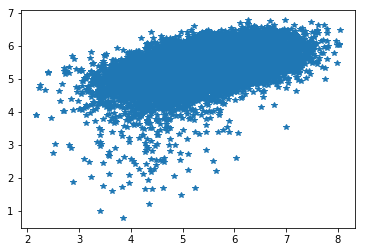

Spearman: 0.524


In [9]:
%matplotlib inline
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

plt.plot(ratings, probs, "*")
plt.show()

print "Spearman: %.3f"%spearmanr(ratings, probs)[0]

In [ ]:
%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt
import random

n_view = 10
img_path = "../dataset/AVA/imgs/"
def imgPlot(imgid, title):
    plt.figure()
    
    plt.title("%s"%title)
    img = Image.open(img_path+"%s.jpg"%imgid)
    plt.imshow(img)
    plt.axis('off')
    
    plt.show()

- The images we most confident were beautiful, and are actually beautiful

In [ ]:
correct_imgs = np.where((preds==1) & (labels==1))[0]
most_correct_imgs = np.argsort(probs[correct_imgs])[::-1][:n_view]
for idx in correct_imgs[most_correct_imgs]:
    imgid = imgids[idx]
    title = "%.4f, %.2f"%(probs[idx], ratings[idx])
    imgPlot(imgid, title)

- The images we most confident were ugly, and are actually ugly

In [ ]:
correct_imgs = np.where((preds==0) & (labels==0))[0]
most_correct_imgs = np.argsort(probs[correct_imgs])[:n_view]
for idx in correct_imgs[most_correct_imgs]:
    imgid = imgids[idx]
    title = "%.4f, %.2f"%(1-probs[idx], ratings[idx])
    imgPlot(imgid, title)

- The images we most confident were beautiful, but are actually ugly

In [ ]:
incorrect_imgs = np.where((preds==1) & (labels==0))[0]
most_incorrect_imgs = np.argsort(probs[incorrect_imgs])[::-1][:n_view]
for idx in incorrect_imgs[most_incorrect_imgs]:
    imgid = imgids[idx]
    title = "%.4f, %.2f"%(probs[idx], ratings[idx])
    imgPlot(imgid, title)

- The images we most confident were ugly, but are actually beautiful

In [ ]:
incorrect_imgs = np.where((preds==0) & (labels==1))[0]
most_incorrect_imgs = np.argsort(probs[incorrect_imgs])[:n_view]
for idx in incorrect_imgs[most_incorrect_imgs]:
    imgid = imgids[idx]
    title = "%.4f, %.2f"%(1-probs[idx], ratings[idx])
    imgPlot(imgid, title)

- The most uncertain labels (ie those with probability closest to 0.5).

In [ ]:
most_uncertain = np.argsort(np.abs(probs-0.5))[:n_view]
for idx in most_uncertain:
    imgid = imgids[idx]
    title = "%.4f, %.2f"%(probs[idx], ratings[idx])
    imgPlot(imgid, title)

- confusion matrix

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    (This function is copied from the scikit docs.)
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = confusion_matrix(labels, preds)
print(cm)
plot_confusion_matrix(cm, ["ugly", "beautiful"], normalize=True)

In [ ]:
cm.astype('float') / cm.sum(axis=0)

## Finetune with more confidence-classfied images

In [ ]:
aesthetic_model.load_weights("./model/aesthetic_mobilenet.h5")

In [ ]:
ft_trainset = filter(lambda x: x[1] > 6.0 or x[1] < 4.0, trainset)
ft_testset = filter(lambda x: x[1] > 6.0 or x[1] < 4.0, testset)
print "Size of Finetune Trainset: %d"%len(ft_trainset)
print "Size of Finetune Testset: %d"%len(ft_testset)
len(filter(lambda x: x[2]==0, ft_trainset))

In [ ]:
aesthetic_model.evaluate_generator(generate_batch(testset, batch_size, target_size=input_shape), 
                                   len(testset) // batch_size)

In [ ]:
optimizer = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
aesthetic_model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

for _pass in range(20):
    aesthetic_model.fit_generator(generate_batch(ft_trainset, batch_size, target_size=input_shape), 
                                  steps_per_epoch=len(ft_trainset) // batch_size, 
                                  validation_data=generate_batch(ft_testset, batch_size, target_size=input_shape), 
                                  validation_steps=len(ft_testset) // batch_size,
                                  epochs=1)
    aesthetic_model.save_weights("./model/aesthetic_mobilenet_pass=%d.h5"%_pass)

In [ ]:
aesthetic_model.load_weights("./model/aesthetic_mobilenet_pass=4.h5")
mobilenet.save_weights("./model/aesthetic_mobilenet_without_top.h5")